In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split

In [2]:
# data load, preprocessing

train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

X_train = train.iloc[:, 1:785].values  # label in first column
y_train = train["label"].values
X_test = test.values

X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

y_train = to_categorical(y_train)

X_train = X_train/255.
X_test = X_test/255.

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, shuffle=True)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(33600, 28, 28, 1)
(8400, 28, 28, 1)
(28000, 28, 28, 1)


In [3]:
# model build

n_models = 3
model = [0] * n_models

for i in range(n_models):
    model[i] = Sequential()

    model[i].add(Conv2D(32, kernel_size=3, padding="same", activation=tf.keras.activations.swish, input_shape=(28, 28, 1)))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size=3, padding="same", activation=tf.keras.activations.swish))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size=3, activation=tf.keras.activations.swish))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(64, kernel_size=3, padding="same", activation=tf.keras.activations.swish))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size=3, padding="same", activation=tf.keras.activations.swish))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size=3, activation=tf.keras.activations.swish))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(128, kernel_size=3, activation=tf.keras.activations.swish))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(256, kernel_size=3, activation=tf.keras.activations.swish))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(256, kernel_size=3, activation=tf.keras.activations.swish))
    model[i].add(BatchNormalization())
    model[i].add(Flatten())
    model[i].add(Dropout(0.4))
    model[i].add(Dense(10, activation='softmax'))

    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [4]:
# utils

# learning rate scheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# for train log
history = [0] * n_models

datagen = ImageDataGenerator(
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        shear_range=0.2,
        fill_mode="nearest")  # randomly shift images vertically (fraction of total height)

datagen.fit(X_train)

In [5]:
batch_size = 64
epochs = 10

for j in range(n_models):
    history[j] = model[j].fit_generator(datagen.flow(X_train, y_train,
                                                     batch_size=batch_size),
                                        epochs=epochs,
                                        steps_per_epoch=X_train.shape[0]//batch_size,
                                        validation_data=(X_valid, y_valid),
                                        callbacks=[annealer], verbose=1)

Epoch 1/10


<ipython-input-5-142ee3f67008>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history[j] = model[j].fit_generator(datagen.flow(X_train, y_train,


525/525 [==============================] - 17s 23ms/step - loss: 1.8698 - accuracy: 0.8602 - val_loss: 33.9806 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 2/10
525/525 [==============================] - 11s 22ms/step - loss: 1.1928 - accuracy: 0.9420 - val_loss: 0.7134 - val_accuracy: 0.9690 - lr: 9.5000e-04
Epoch 3/10
525/525 [==============================] - 11s 22ms/step - loss: 0.8701 - accuracy: 0.9549 - val_loss: 0.5676 - val_accuracy: 0.9780 - lr: 9.0250e-04
Epoch 4/10
525/525 [==============================] - 11s 22ms/step - loss: 0.6591 - accuracy: 0.9633 - val_loss: 0.5107 - val_accuracy: 0.9762 - lr: 8.5737e-04
Epoch 5/10
525/525 [==============================] - 11s 22ms/step - loss: 0.5112 - accuracy: 0.9693 - val_loss: 0.3480 - val_accuracy: 0.9815 - lr: 8.1451e-04
Epoch 6/10
525/525 [==============================] - 11s 22ms/step - loss: 0.4656 - accuracy: 0.9704 - val_loss: 0.3294 - val_accuracy: 0.9788 - lr: 7.7378e-04
Epoch 7/10
525/525 [============================

In [6]:
# make submission csv

results = np.zeros((X_test.shape[0], 10))

for j in range(n_models):
    results = results + model[j].predict(X_test)
results = np.argmax(results, axis=1)

submissions = pd.DataFrame({"ImageId": list(range(1, len(results)+1)), "Label": results})
submissions.to_csv("submission.csv", index=False, header=True)

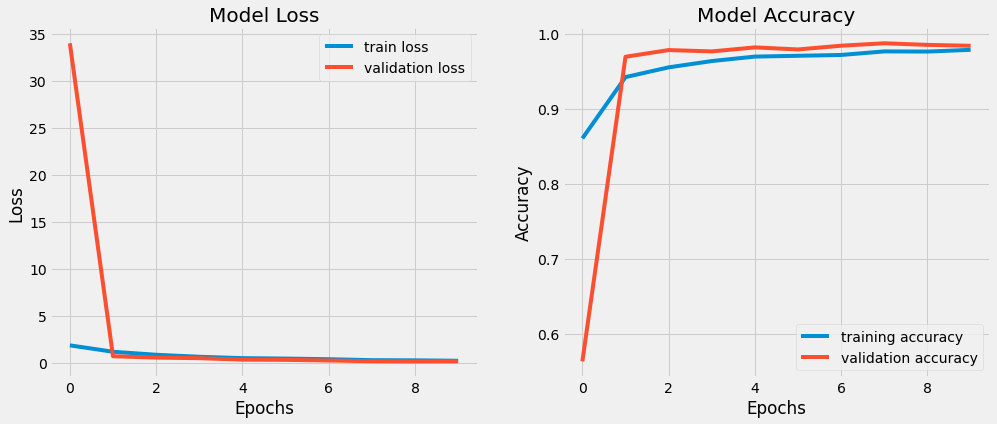

In [7]:
# visualizing
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,6))
plt.subplot(1, 2, 1)
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history[0].history['accuracy'])
plt.plot(history[0].history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()